# Convolutional Neural Network

## Packages

In [1]:
# ----- Tensorflow -----
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras import optimizers as opt

# ----- Transfer learning -----
from keras.applications import NASNetLarge
from keras.applications import EfficientNetB0
from keras.applications import MobileNetV2

# ----- plot -----
import matplotlib.pyplot as plt

# ----- Utility functions -----
from utils import load_data, plot_hist, plot_hist_sideways, _convert_sample

# ------ Data ------
import numpy as np


c:\Users\chris\Desktop\applied_ML_faelles\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
data_dir = "D:/OneDrive - Syddansk Universitet/kandidat/3_semester/Maskinlæring/ds807_anvendt_maskinlæring/eksamen/exam/patch_camelyon"
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=10, batch_size=BATCH_SIZE)

## Transfer Learning
- Discuss and apply transfer learning. Motivate what type of transfer learning you use and how you apply it, including considerations for how to prepare the data for this. Here, be sure to visualize plots of train and validation losses and accuracies.



## Feature Extraction - 1 pass
For the feature extraction approach, we will utilize a large network, since we do not have to train it, we can utilize its size and save computational ressources. In this case we are using NasNetLarge, since it is one of the best performing models in terms of accuracy for image classification. However, it is a HUGE model, and will take time to even load.
However, we will also try with mobilenet v2 since it has been trained on 96 x 96 pixel images

### Helper Functions

In [3]:
def get_x(dataset):
    """
    Returns all y from tensorflow data set
    """
    return tf.convert_to_tensor([x for _, x in dataset.unbatch()])

def get_y(dataset):
    """
    Returns all x from a tensorflow data set
    """
    return tf.convert_to_tensor([y for _, y in dataset.unbatch()])

def get_x_y(dataset):
    """
    Returns all x and y from a tensorflow data set
    """
    return get_x(dataset), get_y(dataset) 

In [4]:
# Y labels 
y_train = get_y(train)
y_val = get_y(val)

# Hyperparams
EPOCHS = 25
LEARNING_RATE = 0.001
OPTIMIZER = opt.Nadam(learning_rate = LEARNING_RATE)

### Feature extractor with MobileNetV2

#### Feature Extractor

In [5]:
# Layers for feature extraction
mobilev2_ft_extractor = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
mobilev2_ft_extractor.trainable = False

#### Classifier

In [6]:
# Full model
x = mobilev2_ft_extractor.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_mobilev2 = Model(inputs = mobilev2_ft_extractor.output, outputs = output)

# Compile model
m_mobilev2.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [7]:
# Extract Features
mobilev2_fts_train = mobilev2_ft_extractor.predict(train)
mobilev2_fts_val = mobilev2_ft_extractor.predict(val)

103/103 [==============================] - 63s 566ms/step


#### Train model with mobilev2 features

In [8]:
history_mobile_v2 = m_mobilev2.fit(x = mobilev2_fts_train, y = y_train, validation_data = (mobilev2_fts_val, y_val), epochs = EPOCHS, batch_size = 32)

Epoch 1/25
820/820 [==============================] - 844s 968ms/step - loss: 0.7194 - accuracy: 0.4990 - val_loss: 0.6946 - val_accuracy: 0.4831
Epoch 2/25
820/820 [==============================] - 773s 943ms/step - loss: 0.6974 - accuracy: 0.5008 - val_loss: 0.6893 - val_accuracy: 0.5337
Epoch 3/25
820/820 [==============================] - 756s 922ms/step - loss: 0.6950 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4620
Epoch 4/25
820/820 [==============================] - 770s 939ms/step - loss: 0.6943 - accuracy: 0.5014 - val_loss: 0.6986 - val_accuracy: 0.4034
Epoch 5/25
820/820 [==============================] - 793s 967ms/step - loss: 0.6936 - accuracy: 0.5051 - val_loss: 0.6970 - val_accuracy: 0.3967
Epoch 6/25
820/820 [==============================] - 720s 877ms/step - loss: 0.6935 - accuracy: 0.5068 - val_loss: 0.6963 - val_accuracy: 0.4812
Epoch 7/25
820/820 [==============================] - 735s 896ms/step - loss: 0.6928 - accuracy: 0.5204 - val_loss: 0.6951 -

### Plot Results

#### MobileNet V2

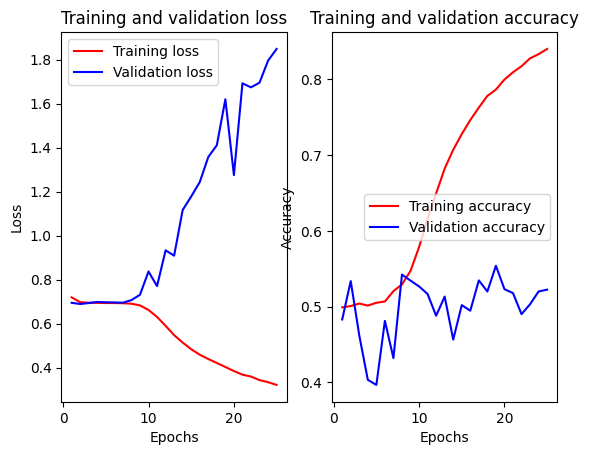

In [9]:
plot_hist_sideways(history_mobile_v2)

## Feature Extraction with multiple passes
Rather than only passing the images through once, we will feed the data through the feature extraction multiple times, we are essentially treating the transfer model as a layer, this allows us to use data augmentation

#### MobileNet V2

In [10]:
# Build classifer
inputs = Input(shape = (96, 96, 3))
x = mobilev2_ft_extractor(inputs)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_mobile_layer = Model(inputs = inputs, outputs = output)

# Compile model
m_mobile_layer.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

In [11]:
history_mobile_layer = m_mobile_layer.fit(train, validation_data = val, epochs = EPOCHS)

Epoch 1/25
820/820 [==============================] - 1228s 1s/step - loss: 0.9657 - accuracy: 0.8352 - val_loss: 0.4354 - val_accuracy: 0.7882
Epoch 2/25
820/820 [==============================] - 1092s 1s/step - loss: 0.2802 - accuracy: 0.8832 - val_loss: 0.3990 - val_accuracy: 0.8267
Epoch 3/25
820/820 [==============================] - 907s 1s/step - loss: 0.2278 - accuracy: 0.9054 - val_loss: 0.4280 - val_accuracy: 0.8261
Epoch 4/25
820/820 [==============================] - 971s 1s/step - loss: 0.1864 - accuracy: 0.9249 - val_loss: 0.5499 - val_accuracy: 0.7980
Epoch 5/25
820/820 [==============================] - 1066s 1s/step - loss: 0.1526 - accuracy: 0.9388 - val_loss: 0.7014 - val_accuracy: 0.7864
Epoch 6/25
820/820 [==============================] - 1073s 1s/step - loss: 0.1269 - accuracy: 0.9511 - val_loss: 0.6492 - val_accuracy: 0.7949
Epoch 7/25
820/820 [==============================] - 1060s 1s/step - loss: 0.1111 - accuracy: 0.9585 - val_loss: 0.7882 - val_accuracy: 0

### Plot results

#### MobileNet

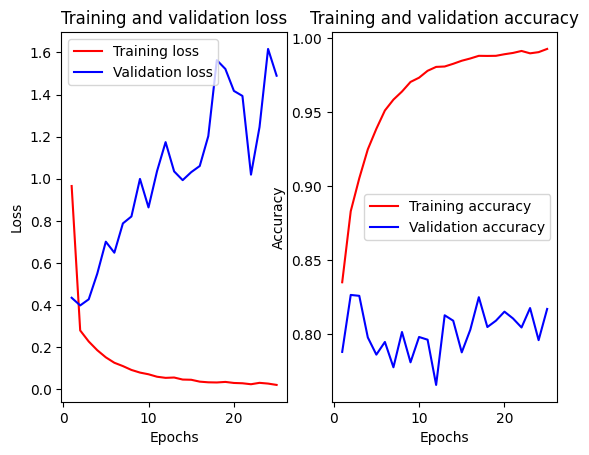

In [12]:
plot_hist_sideways(history_mobile_layer)